

The goal of this assignment is to develop and test two text classification systems: 

- **Task 1:** sentiment analysis, in particular to predict the sentiment of movie review, i.e. positive or negative (binary classification).
- **Task 2:** topic classification, to predict whether a news article is about International issues, Sports or Business (multiclass classification).


For that purpose, you will implement:

- Text processing methods for extracting Bag-Of-Word features, using (1) unigrams, bigrams and trigrams to obtain vector representations of documents. Two vector weighting schemes should be tested: (1) raw frequencies (**3 marks; 1 for each ngram type**); (2) tf.idf (**1 marks**). 
- Binary Logistic Regression classifiers that will be able to accurately classify movie reviews trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 1. 
- Multiclass Logistic Regression classifiers that will be able to accurately classify news articles trained with (1) BOW-count (raw frequencies); and (2) BOW-tfidf (tf.idf weighted) for Task 2. 
- The Stochastic Gradient Descent (SGD) algorithm to estimate the parameters of your Logistic Regression models. Your SGD algorithm should:
    - Minimise the Binary Cross-entropy loss function for Task 1 (**3 marks**)
    - Minimise the Categorical Cross-entropy loss function for Task 2 (**3 marks**)
    - Use L2 regularisation (both tasks) (**1 mark**)
    - Perform multiple passes (epochs) over the training data (**1 mark**)
    - Randomise the order of training data after each pass (**1 mark**)
    - Stop training if the difference between the current and previous validation loss is smaller than a threshold (**1 mark**)
    - After each epoch print the training and development loss (**1 mark**)
- Discuss how did you choose hyperparameters (e.g. learning rate and regularisation strength)?  (**2 marks; 0.5 for each model in each task**).
- After training the LR models, plot the learning process (i.e. training and validation loss in each epoch) using a line plot (**1 mark; 0.5 for both BOW-count and BOW-tfidf LR models in each task**) and discuss if your model overfits/underfits/is about right.
- Model interpretability by showing the most important features for each class (i.e. most positive/negative weights). Give the top 10 for each class and comment on whether they make sense (if they don't you might have a bug!).  If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain? (**2 marks; 0.5 for BOW-count and BOW-tfidf LR models respectively in each task**)


### Data - Task 1 

The data you will use for Task 1 are taken from here: [http://www.cs.cornell.edu/people/pabo/movie-review-data/](http://www.cs.cornell.edu/people/pabo/movie-review-data/) and you can find it in the `./data_sentiment` folder in CSV format:

- `data_sentiment/train.csv`: contains 1,400 reviews, 700 positive (label: 1) and 700 negative (label: 0) to be used for training.
- `data_sentiment/dev.csv`: contains 200 reviews, 100 positive and 100 negative to be used for hyperparameter selection and monitoring the training process.
- `data_sentiment/test.csv`: contains 400 reviews, 200 positive and 200 negative to be used for testing.

### Data - Task 2

The data you will use for Task 2 is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.


### Submission Instructions

You should submit a Jupyter Notebook file (assignment1.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`).

You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are **free to use any functionality from the [Python Standard Library](https://docs.python.org/2/library/index.html), NumPy, SciPy and Pandas.** You are not allowed to use any third-party library such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras etc..

Please make sure to comment your code. You should also mention if you've used Windows (not recommended) to write and test your code. There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results is as important as the accuracy itself. 

In [71]:
import math
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from scipy.special import softmax as sftmx #used to test my function, allowed 
# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)

## Load Raw texts and labels into arrays

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [380]:
# Written and tested on Windows 10

In [3]:
data_tr = pd.read_csv(('./data_sentiment/train.csv'),header = None) #Do not use first row as column names
data_tr.columns=['text', 'label']
data_dev = pd.read_csv(('./data_sentiment/dev.csv'),header = None)
data_dev.columns=['text', 'label']
data_test =pd.read_csv(('./data_sentiment/test.csv'),header = None )
data_test.columns=['text', 'label']

In [5]:
#Create Empty Numpy array of column size of dataframe
ArrayTR = np.empty(data_tr.shape[0])
ArrayDev = np.empty(data_dev.shape[0])
ArrayTest = np.empty(data_test.shape[0])

#Create Empty Lists
data_tr_textlist =list()
data_dev_textlist =list()
data_test_textlist =list()

x = (data_tr.iloc[:]) # temp location for dataframe
x.columns=['text', 'label'] #assign labels
y = x.drop('text',axis =1)   #Delete First Column to get a dataframe containing just label
x = x.drop('label',axis =1) #Delete second column to get a dataframe containing just the text
data_tr_textlist = (x.values.tolist()) # Convert text portion to list
ArrayTR = y.to_numpy() # Convert label dataframe to Numpy

x = data_dev.iloc[:] # temp location for dataframe
x.columns=['text', 'label']#assign labels
y = x.drop('text',axis = 1 ) #Delete First Column to get a dataframe containing just label
x = x.drop('label',axis =1) #Delete second column to get a dataframe containing just the text
data_dev_textlist = (x.values.tolist()) # Convert text portion to list
ArrayDev = y.to_numpy() # Convert label dataframe to Numpy

x = data_test.iloc[:] # temp location for dataframe
x.columns=['text', 'label']#assign labels
y = x.drop('text',axis =1 ) #Delete First Column to get a dataframe containing just label
x = x.drop('label',axis =1) #Delete second column to get a dataframe containing just the text
data_test_textlist = (x.values.tolist()) # Convert text portion to list
ArrayTest = y.to_numpy() # Convert label dataframe to Numpy

# Bag-of-Words Representation 


To train and test Logisitc Regression models, you first need to obtain vector representations for all documents given a vocabulary of features (unigrams, bigrams, trigrams).


## Text Pre-Processing Pipeline

To obtain a vocabulary of features, you should: 
- tokenise all texts into a list of unigrams (tip: using a regular expression) 
- remove stop words (using the one provided or one of your preference) 
- compute bigrams, trigrams given the remaining unigrams
- remove ngrams appearing in less than K documents
- use the remaining to create a vocabulary of unigrams, bigrams and trigrams (you can keep top N if you encounter memory issues).


In [9]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what', 
             'his', 'her', 'they', 'them', 'from', 'with', 'its','also','so','there','their','The']

### N-gram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.

See the examples below to see how this function should work.

In [10]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', stop_words= stop_words, vocab=set()):
  

    ####Tokenisation#######  
    com = re.compile(token_pattern)
    x_raw = com.findall(x_raw)           
    # vocab = re.findall(token_pattern,vocab)

   # x_raw = list(x_raw.split())     #Split Sentence into seperate words then store as list

    
 #####Remove Stop words########
    x_raw=[word for word in x_raw if word not in stop_words]
    for word in stop_words:
        for word2 in x_raw:
            if word == word2:
                x_raw.remove(word)
            

            
    #print(vocab)
    
#######Return Vocab#####
    #vocab needs to normalised
    vocab1 = str(vocab)
    vocab1 = re.findall(token_pattern,vocab1)
    commachar = ","
    spacechar = ''
    if ((len(vocab1)) != 0): #Check if set is empty
        vocablist = []
        for word in x_raw:
            for word2 in vocab1:
                if ((word == word2) & (word != commachar) & (word != spacechar)& (word2 not in vocablist)): #remove commas & match words in text &vocab
                    vocablist.append(word.replace(" ", "")) ## remove whitespace characters
                   # print(vocablist)

    noofngrams=[]
    ngrams_list = []
    if ngram_range == (1,3):
        noofngrams= [1,2,3]
    if ngram_range == (1,2):
        noofngrams= [1,2]
        
    y =[]

    #Extract Ngrams
    for n in noofngrams:
        if (len(vocab)) == 0:
                for num in range(0, len(x_raw)):
                    ngram = ' '.join(x_raw[num:num + n])
                    #if ngram not in ngrams_list:
                    if ((ngram != '')):
                        ngrams_list.append(ngram)
                        if ngram not in y:
                            y.append(ngram)
                            
        if (len(vocab)) != 0:
                for n in range(0,len(vocab1)):
                    for num in range(0, len(vocablist)):
                        if len(vocablist[num]) != 0:
                                ngram = ' '.join(vocablist[num:num + n])
                               
                                if ((ngram != '')): # ((ngram not in ngrams_list) & 
                                    ngrams_list.append(ngram)

                                    if ngram not in y:
                                        y.append(ngram)
            
    x= ngrams_list 
    return x,y # y is unique ngram list, x is list including duplicates for vectorisation

In [11]:
x1,y1 = extract_ngrams("this is a great movie to watch", 
               ngram_range=(1,3), 
               stop_words=stop_words)
print(y1)

['great', 'movie', 'watch', 'great movie', 'movie watch', 'great movie watch']


Note that it is OK to represent n-grams using lists instead of tuples: e.g. `['great', ['great', 'movie']]`

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab

Hint: it should make use of the `extract_ngrams` function.

In [12]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    
    #Define empty placeholder variables
    df=  Counter()
    ngram_counts = Counter()
    vocab = set()
    df1 = list()
    df2 = Counter()
    #com = re.compile(token_pattern)
    #X_raw = com.findall(X_raw)     
    vocab1 = set()
    
    for x_raw in X_raw:
        x_raw = str(x_raw)
        com = re.compile(token_pattern)
        x_raw = com.findall(x_raw)           
        x_raw = str(x_raw)
        x_raw.replace(" ", "")
        x_raw.replace("[","")
        x_raw.replace("]","")
        y,x = extract_ngrams(x_raw, ngram_range, token_pattern, stop_words)
        #calling extract_ngrams deals with tokenisation,stop words,ngram range and ngram extraction
        for item in x:
            df[item] += 1
            if df[item]> min_df: # Only keep above the minimum
                df2[item] += 1
            
            if (str(item) not in vocab) & (len(vocab) < keep_topN): #stop adding to vocab once cap is reached
            #vocab.add(str(x))
                 vocab.add(str(item)) #need to remove brackets as i think its passing
        
        for string in x:
            if string in ngram_counts:
                    ngram_counts[string] += 1 #len 998359
            else:
                    ngram_counts[string] = 1
    #df1.append(df2.most_common(keep_topN)) #Keep only the specified amount of N
    #ngram_counts.append(ngram_counts.most_common(keep_topN))
    #vocab = list(vocab)
    df = df2
    
    
#######assign top ngrams to vocab set###########################
   # vocab1 = set()
    for item in ngram_counts.most_common(keep_topN):
        
            # type(item)) item is a tupple
        if (len(vocab1) < keep_topN)  :
                vocab1.add(item[0])
                
    vocab = vocab1
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of n-grams:

In [453]:
vocab, df, ngram_counts = get_vocab(data_tr_textlist, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
print(len(vocab))
print()
print(list(vocab)[:100])
print()
print(df.most_common()[:10])

5000

['many times', 'film plot', 'episodes', 'coherent', 'greg', 'pointless', 'passes', 'books', 'crossing', 'beaten', 'possible', 'proving', 've ever', 'principal', 'convicted', 'starts', 'ignored', 'pg', 'vs', 'hoped', 'time', 'than', 'team', 'cop', 'ad', 'opening', 'day', 'primary', 'pivotal', 'uplifting', 'minute', 'sounds', 'anne', 'makeup', 'files', 'creatures', 'citizens', 'one such', 'tad', 'provided', 'make', 'international', 'almost every', 'stranger', 'something like', 'large', 'throughout movie', 'japanese', 'heck', 'york', 'drive', 'signs', 'visually', 'critically', 'don want', 'sudden', 'crimes', 'know', 'greatly', 'office', 'end movie', 'bad guys', 'voice over', 'crisis', 'pretty good', 'only two', 'trailers', 'slow', 'inevitably', 'alas', 'awfully', 'below', 'record', 'glaring', 'finest', 'like all', 'natasha', 'neve campbell', 'false', 'diamond', 'other characters', 'decides', 'but still', 'species', 'dress', 'father', 'class', 'cusack', 'one year', 'one few', 'anthon

Then, you need to create vocabulary id -> word and id -> word dictionaries for reference:

In [454]:
list_of_vocab = list(vocab)
vocab_id = {i:list_of_vocab[i] for i in range(len(vocab))}

Now you should be able to extract n-grams for each text in the training, development and test sets:

## Vectorise documents 

Next, write a function `vectoriser` to obtain Bag-of-ngram representations for a list of documents. The function should take as input:
- `X_ngram`: a list of texts (documents), where each text (doc) is represented as list of n-grams in the `vocab`
- `vocab`: a set of n-grams to be used for representing the documents

and return:
- `X_vec`: an array with dimensionality N x |vocab| where N is the number of documents and |vocab| is the size of the vocabulary. Each element of the array should represent the frequency of a given n-gram in a document.


In [448]:
#Take training set as input
#divide into doc
#extract each ngram for each doc
#Count ngram in doc using counter
#iterate counter through the vocab and assign counts in that order
def Extract_X_ngram(data_tr_textlist):
    X_ngram =[]
    for line in data_tr_textlist:
        ngram,p = list(extract_ngrams(str(line),stop_words= stop_words))
        X_ngram.append(ngram)
    return X_ngram    

X_ngram = Extract_X_ngram(data_tr_textlist)
#print(Counter(X_ngram[0]))

In [17]:
def vectorise(X_ngram, vocab):
    N = len(X_ngram) #Get Dimensions #1400 x 5000 for training set
    SizeOfSet = len(vocab)
    X_vec = np.zeros((N,SizeOfSet))
    counter_vect = Counter()
    i = 0
    temp_loc =0
    
    for row in X_ngram:
        counter_vect = Counter(row)
        #print(counter_vect)
        for item in row:
            if item in vocab:
                temp_loc= list_of_vocab.index(item) #get vocab_id of word
                X_vec[i][temp_loc] = counter_vect[item]#assign count corresponding to vocabID
        i+=1
    return X_vec

Finally, use `vectorise` to obtain document vectors for each document in the train, development and test set. You should extract both count and tf.idf vectors respectively:

#### Count vectors

In [455]:
X_tr_count = vectorise(X_ngram,vocab)
#print(X_tr_count)

In [456]:
X_tr_count.shape #(1400, 5000)
#type(X_tr_count)

(1400, 5000)

In [457]:
X_tr_count[:2,:50]

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 1., 1., 0., 0., 2., 1., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0.,
        0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 2., 3., 0., 0., 0., 1., 2., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.,
        0., 0.]])

#### TF.IDF vectors

First compute `idfs` an array containing inverted document frequencies (Note: its elements should correspond to your `vocab`)

In [21]:
idf =[] * 5000
for i in range(5000):
        df[list_of_vocab[i]] += 1 #Smoothing
        idf.append(math.log(len(data_tr_textlist)/df[list_of_vocab[i]]))
#print(idf[:10])

In [22]:
N = len(X_ngram) #Get Dimensions #1400 x 5000 for training set
SizeOfSet = len(vocab)
X_tr_tfidf = np.zeros((N,SizeOfSet))
X_tr_tfidf=np.multiply(idf,X_tr_count)         

In [23]:
X_tr_tfidf[1,:50]
#print(len(X_tr_tfidf))

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.94000726, 1.28247491, 0.        , 0.        , 0.        ,
       2.04022083, 2.87217005, 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.68037199, 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ])

# Binary Logistic Regression

After obtaining vector representations of the data, now you are ready to implement Binary Logistic Regression for classifying sentiment.

First, you need to implement the `sigmoid` function. It takes as input:

- `z`: a real number or an array of real numbers 

and returns:

- `sig`: the sigmoid of `z`

In [24]:
def sigmoid(z):
    return (1/(1 + np.exp(-z)))

Then, implement the `predict_proba` function to obtain prediction probabilities. It takes as input:

- `X`: an array of inputs, i.e. documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_proba`: the prediction probabilities of X given the weights

In [25]:
def predict_proba(X,w):#preds_proba=np.apply_along_axis(sigmoid, 1, z)
    z=np.dot(X,w)
    preds_proba =sigmoid(z)
    return preds_proba

Then, implement the `predict_class` function to obtain the most probable class for each vector in an array of input vectors. It takes as input:

- `X`: an array of documents represented by bag-of-ngram vectors ($N \times |vocab|$)
- `weights`: a 1-D array of the model's weights $(1, |vocab|)$

and returns:

- `preds_class`: the predicted class for each x in X given the weights

In [26]:
 def predict_class(X,w):
    probability = (predict_proba(X,w))
    
    preds_class = np.around(probability) # round value
    preds_te = []
    for i in preds_class:
    #y =(0 if P(y = 1|x;w) < 0.5 1 otherwise
        if i < 0.5:
            preds_te.append(0)
        else:
            preds_te.append(1)
    
    return preds_te

To learn the weights from data, we need to minimise the binary cross-entropy loss. Implement `binary_loss` that takes as input:

- `X`: input vectors
- `Y`: labels
- `weights`: model weights
- `alpha`: regularisation strength

and return:

- `l`: the loss score

In [449]:
#L2
#Reference: Lecture 2
def binary_loss(X,Y,w,alpha=0.0001):
    #sum_of_weight = (np.sum(np.square(w)) * alpha)
    #l = np.sum(Y-np.square(np.dot(X,w)))
    #l = (sum_of_weight + l)/ len(Y)
    #print(l)
    Y_length = len(Y)
    prediction =  np.atleast_2d(predict_proba(X,w))# otherwise shape (len(Y),) and unable to use in dot product
   
    #alpha_array = alpha* np.dot(w,w)
    
    log_array1 = np.log(prediction + alpha) #log(P(y = 1))
    log_array2 = np.log(1-prediction + alpha)#log(1−P(y = 1)) 
    
    Class_1 = (np.dot(Y,log_array1))
    Temp = (1-Y)
    #Class_2 = np.dot(Temp, log_array2) 
    
    #print(type(Class_1))
    #print(Class_1.shape)
    #Result = (np.sum(np.array(Class_1) ,np.array(Class_2)))
    #Result = Class_1 - Class_2
    #Result = -(Result / Y_length)
    Result = ((-Class_1) + (Y*log_array2) -(log_array2)) # ylogp -(1-y)log(1-p) +alpha*w.T*w
    #print(type(Result))
    #print(Result)
    Result = np.sum(Result,axis = 1) / Y_length
    Result = np.sum(Result)
    return Result

Now, you can implement Stochastic Gradient Descent to learn the weights of your sentiment classifier. The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `alpha`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [423]:
def SGD(X_tr, Y_tr, X_dev=[], Y_dev=[], loss="binary", lr=0.0001, alpha=0.0001, epochs = 10, tolerance= 0.000001, print_progress=True):
    
    training_loss_history = [] #empty lists for holding the loss values
    validation_loss_history = []
    w= np.zeros(X_tr[0].shape) # w starts as 0
    Y_length = len(Y_tr)
    Y_dev_length = len(Y_dev)
    
    
    ###Reference: Lecture 2 Slide 57
    for ep in range(epochs):
        
        np.random.seed(ep+3)#shuffle each epoch
        shuffle =np.random.permutation(Y_length) # seed is set, permutation is a fixed transformation
        X_tr , Y_tr = X_tr[shuffle],Y_tr[shuffle]# the correct label will therefore be maintained
        
        for row,value in zip(X_tr,Y_tr):
            prediction = predict_proba(row,w)
            deriv = (row*((prediction) - int(value))) + (2*alpha* w)
            #deriv = (-row(int(value)*prediction )   +(2*alpha* w) 
            w = (w -(lr*deriv))
            loss_train = binary_loss(X_tr,Y_tr,w,alpha)/Y_length #calculate loss for both sets
            loss_dev = binary_loss(X_dev,Y_dev,w,alpha)/Y_dev_length
            
        training_loss_history.append(loss_train)
        validation_loss_history.append(loss_dev)
    
        if print_progress == True: #Print progress
            print("Epoch: " + str((int(ep + 1))) + " Training Loss: " + str(loss_train) + "| Validation Loss: " + str(loss_dev))
            
        ##stop if tolerance threshold is reached and it is not the first epoch
        ## Value is converging 
        if (((abs(validation_loss_history[(ep-1)] - validation_loss_history[(ep)])) < tolerance) and (ep > 0)):
            print("Tolerance reached")
            break
    #print(ep)
    return w, training_loss_history, validation_loss_history,ep

## Train and Evaluate Logistic Regression with Count vectors

First train the model using SGD:

In [29]:
##Calculate X_dev_count & X_test_count
XDev_ngram = Extract_X_ngram(data_dev_textlist)
X_dev_count = vectorise(XDev_ngram,vocab)

XTest_ngram = Extract_X_ngram(data_test_textlist)
X_test_count = vectorise(XTest_ngram,vocab)              

In [390]:
w_count, training_loss_history, validation_loss_history,epoch_max = SGD(X_tr=X_tr_count,Y_tr = ArrayTR, 
                                             X_dev= X_dev_count, 
                                             Y_dev=ArrayDev, 
                                             lr=0.00001,                                   
                                             alpha=0.00001, 
                                             epochs=10)

Epoch: 1 Training Loss: 0.6933409801747362| Validation Loss: 0.6932952837650415
Epoch: 2 Training Loss: 0.6937766589235985| Validation Loss: 0.6936245404978504
Epoch: 3 Training Loss: 0.6944227647181583| Validation Loss: 0.6941097308889659
Epoch: 4 Training Loss: 0.694726762231987| Validation Loss: 0.6942845315363971
Epoch: 5 Training Loss: 0.6952398556388213| Validation Loss: 0.6946285374754271
Epoch: 6 Training Loss: 0.6959564596365123| Validation Loss: 0.6951314210478655
Epoch: 7 Training Loss: 0.6968552366079026| Validation Loss: 0.6957709159841886
Epoch: 8 Training Loss: 0.6977341310278613| Validation Loss: 0.6963906020863944
Epoch: 9 Training Loss: 0.6987638768692601| Validation Loss: 0.6971232449947152
Epoch: 10 Training Loss: 0.699776539335414| Validation Loss: 0.6978401132475621


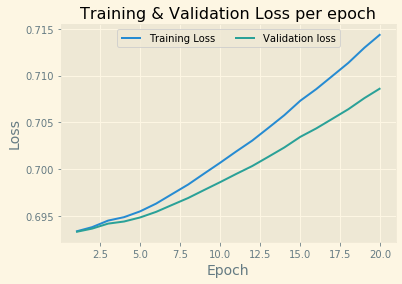

In [167]:
epochs_arr = np.arange(1, (epoch_max + 2), 1)

with plt.style.context('Solarize_Light2'):
    plt.plot(epochs_arr,training_loss_history, label = "Training Loss")
    plt.plot(epochs_arr,validation_loss_history,label = "Validation loss")
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training & Validation Loss per epoch For Count Vectors')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
plt.show()

In [ ]:
#Note that my loss is increasing, not sure why that is as my fmeasure and printing top words would indicate 
#that the model is being trained properly
#possible bug

## Discussion

For some reason my loss is increasing. This would indicate a bug in my loss function. However my model is still learning reasonably well achieving a relatively high f measure and accuracy. The Fmeasure is not extremely close to 1 which could indicate overfitting and does not deviate far from 1 and thus isnt underfitting. The loss increases with a exponential relationship where the actual graph should follow a natural log relationship and should slowly converge to a final value.

Compute accuracy, precision, recall and F1-scores:

In [440]:
preds_te_count_test = predict_class(X_test_count,w_count)
print('Accuracy:', accuracy_score(ArrayTest,preds_te_count_test))
print('Precision:', precision_score(ArrayTest,preds_te_count_test))
print('Recall:', recall_score(ArrayTest,preds_te_count_test))
print('F1-Score:', f1_score(ArrayTest,preds_te_count_test))

Accuracy: 0.7575
Precision: 0.7229437229437229
Recall: 0.835
F1-Score: 0.7749419953596286


Finally, print the top-10 words for the negative and positive class respectively.

In [443]:
pos_ind = np.argpartition(w_count,-10)[-10:] # indexes of 10 largest weights  

positive_words_ind =[]
for i in pos_ind:
    positive_words_ind.append(vocab_id[i])
    
print(positive_words_ind)

['story', 'many', 'best', 'most', 'well', 'very', 'world', 'film', 'life', 'great']


In [445]:
neg_ind = np.argpartition(w_count,10)[:10] # indexes of 10 largest weights  
#neg_weight =[]
#vocab_id_shuffled = keys[shuffle]

neg_words_ind =[]
for i in neg_ind:
    neg_words_ind.append(vocab_id[i])
        
print(neg_words_ind)

['plot', 'even', 'bad', 'no', 'movie', 'why', 'if', 'only', 'any', 'get']


If we were to apply the classifier we've learned into a different domain such laptop reviews or restaurant reviews, do you think these features would generalise well? Can you propose what features the classifier could pick up as important in the new domain?

## Discussion
Some of the words returned are ubiquitous within positive reviews regardless of domain e.g great, most, best. I think the classifier would generalise well if ported to laptop reviews or restaurant reviews. The important features of laptop reviews could be lightweight, fast, battery life etc. for restaurant reviews it could tasty, fast, hospitable etc. Notice there would be some crossover with words such as cheap, fast and friendly. The bag of words approach may fail to classify some features such as battery life, for example, short battery life and good battery life. If battery life is extracted as a top n-gram then unclear if battery life is a positive or negative feature. 


However some words returned as domain specific e.g plot. The model may be able to classify to some degree but the expected f-measure would be sub-optimal.

## Train and Evaluate Logistic Regression with TF.IDF vectors

Follow the same steps as above (i.e. evaluating count n-gram representations).


In [32]:
##calculate tfidf for each set for SGD using tfidf, same process as before
## size of set remains constant 
idf =[] * 5000
for i in range(5000):
        idf.append(math.log(len(data_dev_textlist)/df[list_of_vocab[i]]))
N = len(XDev_ngram)
X_dev_tfidf = np.zeros((N,SizeOfSet)) # size of vocab remains constant
X_dev_tfidf=np.multiply(idf,X_dev_count)                 
        
idf =[] * 5000        
for i in range(5000):
        idf.append(math.log(len(data_test_textlist)/df[list_of_vocab[i]]))
N = len(XTest_ngram)
X_test_tfidf = np.zeros((N,SizeOfSet))
X_test_tfidf=np.multiply(idf,X_test_count)    

In [446]:
w_tfidf, trl, devl,epoch_max2 = SGD(X_tr=X_tr_tfidf,Y_tr =ArrayTR, 
                         X_dev=X_dev_tfidf, 
                         Y_dev=ArrayDev, 
                         lr=0.0001, 
                         alpha=0.00001, 
                         epochs=20)

Epoch: 1 Training Loss: 0.7344722166909443| Validation Loss: 0.6968951526794576
Epoch: 2 Training Loss: 0.7913573100042479| Validation Loss: 0.7039167029497782
Epoch: 3 Training Loss: 0.8485553967724822| Validation Loss: 0.7081285058589616
Epoch: 4 Training Loss: 0.8944193665434588| Validation Loss: 0.7191387255642958
Epoch: 5 Training Loss: 0.9407515200717382| Validation Loss: 0.7254022037778043
Epoch: 6 Training Loss: 0.9841868421757868| Validation Loss: 0.7298595090673858
Epoch: 7 Training Loss: 1.0244540149225938| Validation Loss: 0.7338466483936428
Epoch: 8 Training Loss: 1.0615787434109973| Validation Loss: 0.7385443370979905
Epoch: 9 Training Loss: 1.097464969969084| Validation Loss: 0.7404096886730213
Epoch: 10 Training Loss: 1.1291940546817831| Validation Loss: 0.7467755244438586
Epoch: 11 Training Loss: 1.1612002519265598| Validation Loss: 0.7489272059455669
Epoch: 12 Training Loss: 1.1893239558168653| Validation Loss: 0.7555851134027541
Epoch: 13 Training Loss: 1.21792395946

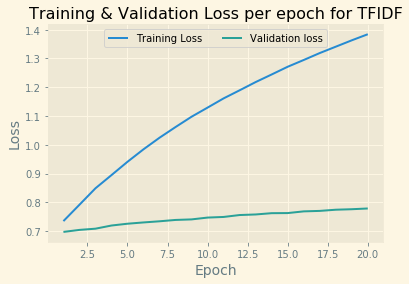

In [450]:
#print(epoch_max)
epochs_arr = np.arange(1, epoch_max2+2, 1)
#x = np.linspace(0, range(epochs))
with plt.style.context('Solarize_Light2'):
    plt.plot(epochs_arr,trl, label = "Training Loss")
    plt.plot(epochs_arr,devl,label = "Validation loss")
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training & Validation Loss per epoch for TFIDF')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
plt.show()

## Discussion

For some reason my loss is increasing. This would indicate a bug in my loss function. However my model is still learning reasonably well achieving a relatively high f measure and accuracy. The Fmeasure is not extremely close to 1 which could indicate overfitting and does not deviate far from 1 and thus isnt underfitting. 
The loss increases with a linear relationship where the actual graph should follow a natural log relationship and should slowly converge to a final value. This is in contrast to the counts case. The validation loss follows more of a square root relationship in contrast to the expontential relationship of the counts case. The relationship for both variables should be that of a natural logarthim.

In [451]:
#preds_te_count = predict_class(X_tr_tfidf, w_tfidf)
preds_te_test = predict_class(X_test_tfidf,w_tfidf)

print('Accuracy:', accuracy_score(ArrayTest,preds_te_test))
print('Precision:', precision_score(ArrayTest,preds_te_test))
print('Recall:', recall_score(ArrayTest,preds_te_test))
print('F1-Score:', f1_score(ArrayTest,preds_te_test))

Accuracy: 0.775
Precision: 0.72
Recall: 0.9
F1-Score: 0.7999999999999999


Print top-10 most positive and negative words:

In [441]:
pos_ind = np.argpartition(w_tfidf,-10)[-10:] # indexes of 10 largest weights  
positive_words_ind =[]
for i in pos_ind:
    positive_words_ind.append(vocab_id[i])  
print(positive_words_ind)

['american', 'perfect', 'perfectly', 'jackie', 'cameron', 'disney', 'life', 'world', 'war', 'great']


In [442]:
neg_ind = np.argpartition(w_tfidf,10)[:10] # indexes of 10 largest weights  
neg_words_ind =[]
for i in neg_ind:
    neg_words_ind.append(vocab_id[i])
print(neg_words_ind)

['bad', 'worst', 'boring', 'why', 'supposed', 'harry', 'stupid', 'ridiculous', 'nothing', 'waste']


## Discussion
The words returned for count and tfidf make sense, with words associated with a positive sentiment in the positive class and the same for the negative class. Certain terms returned are ambigious such as "harry" and "supposed" however these could be removed using a stop list. Furthermore the words returned for tfidf SGD seem to generalise a positive or negative sentiment better than the count SGD. 

While the accuracy of the tfidf is lower, the Fmeasure is very high and almost equal to 1. 0.77 is still an acceptable value for accuracy. It is expected that tfidf would score on the whole better than count due to the large document set with a large amount of text per document.


### Discuss how did you choose model hyperparameters ? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

## Discussion

With increasing epochs, the loss value converges. With high regularisation strength the model is less likely to overfit as a constant is being added. The learning rate dictates how quickly to descend the gradient, a larger learning rate will converge quicker but may overshoot the minimum. A smaller learning rate will take longer to converge but there is no chance of overshooting the minimum.Ideally we choose a large learning rate then decrease the learning rate with epochs to ensure convergence.A small amount of epochs is likely to underfit whereas a large amount of epochs will overfit (if our data is length 1400 and we do 1400 shuffles eventually the weights will represent the training data exactly) 

A small learning rate will favour a large amount of epochs as there are more iterations to get closer to the final converging value. If the data is decreasing fairly constitenly i.e decreasing linear gradient then the learning rate should be increased. A large regularisation strength may lead to many falsely classified predictions due to the fact the value will be larger and potentially rounded to the wrong class.

The parameters used for SGD were derived by trial and error (code removed due to runtime and cleanliness) and evaluated using the loss function and fmeasure values. Learning rate was changed while the alpha remained fixed. Once the best performing learning rate was choosen then learning rate was fixed and alpha was changed. Alpha was multiplied by 10 each time until the best value was choosen. This is not the best way of choosing learning parameters, the best way to choose learning parameters is to build a cross validator pipeline using a python library like pyspark.

Epoch was then decided based on F-measure once the other parameters were chosen.I defined a tolerance for f-measure and worked out the amount of epochs to reach the tolerance. The value of epoch obtained was fairly low which is suprising as usually epoch needs to be considerably larger. This could be because my code does multiple passes in one iteration of epoch. If runtime was not a consideration then additional epochs could be accomplished.


Runtime and PC memory usuage have to be taken into consideration too so I have chosen a middle ground for the number of epochs. In my testing convergence tends to happen around the ~100 epoch mark. My program uses 5 gigabytes of RAM during the SGD call. A HPC was used to test the effect of epoch due to the quicker performance.The figure below demonstrates an example for the BOW-count vectors.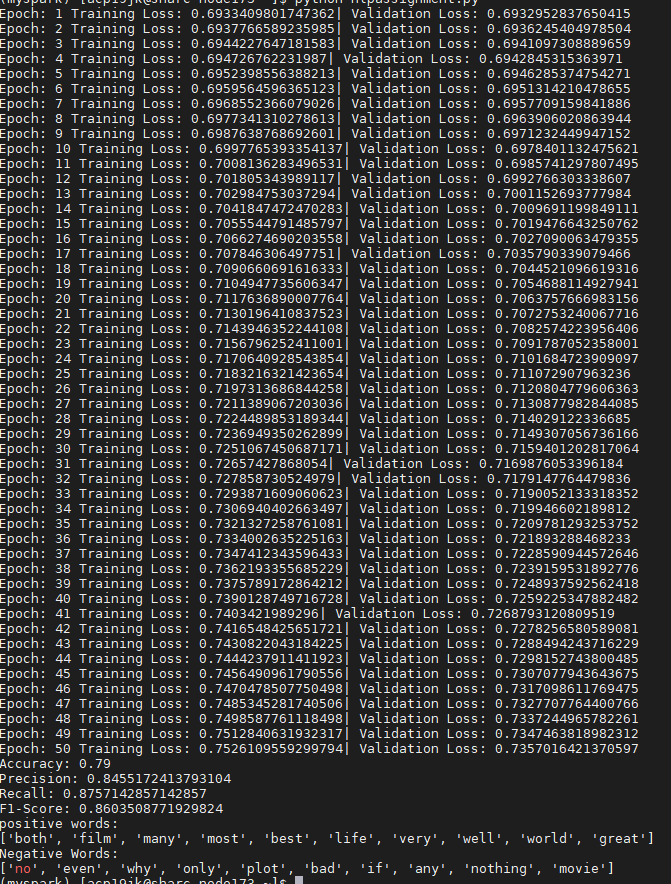 



## Full Results


| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.72 |0.84   |0.77   |
| BOW-tfidf  | 0.72  |0.90   |0.80   |


# Multi-class Logistic Regression 

Now you need to train a Multiclass Logistic Regression (MLR) Classifier by extending the Binary model you developed above. You will use the MLR model to perform topic classification on the AG news dataset consisting of three classes:

- Class 1: World
- Class 2: Sports
- Class 3: Business

You need to follow the same process as in Task 1 for data processing and feature extraction by reusing the functions you wrote.

In [33]:
##Data processing almost same as task 1 except label text are swapped
Topic_data_tr = pd.read_csv(('./data_topic/train.csv'),header = None) #Do not use first row as column names
Topic_data_tr.columns=['label', 'text']
Topic_data_dev = pd.read_csv(('./data_topic/dev.csv'),header = None)
Topic_data_dev.columns=['label', 'text']
Topic_data_test =pd.read_csv(('./data_topic/test.csv'),header = None )
Topic_data_test.columns=['label', 'text'] 

#Create Empty Numpy array of column size of dataframe
ArrayTR_Topic = np.empty(Topic_data_tr.shape[0])
ArrayDev_Topic = np.empty(Topic_data_dev.shape[0])
ArrayTest_Topic = np.empty(Topic_data_test.shape[0])

#Create Empty Lists
topic_tr_textlist =list()
topic_dev_textlist =list()
topic_test_textlist =list()

x = (Topic_data_tr.iloc[:]) # temp location for dataframe
x.columns=['label', 'text'] #assign labels
y = x.drop('text',axis =1)   #Delete First Column to get a dataframe containing just label
x = x.drop('label',axis =1) #Delete second column to get a dataframe containing just the text
topic_tr_textlist = (x.values.tolist()) # Convert text portion to list
ArrayTR_Topic = y.to_numpy() # Convert label dataframe to Numpy

x = (Topic_data_dev.iloc[:]) # temp location for dataframe
x.columns=['label', 'text'] #assign labels
y = x.drop('text',axis =1)   #Delete First Column to get a dataframe containing just label
x = x.drop('label',axis =1) #Delete second column to get a dataframe containing just the text
topic_dev_textlist = (x.values.tolist()) # Convert text portion to list
ArrayDev_Topic = y.to_numpy() # Convert label dataframe to Numpy

x = (Topic_data_test.iloc[:]) # temp location for dataframe
x.columns=['label', 'text'] #assign labels
y = x.drop('text',axis =1)   #Delete First Column to get a dataframe containing just label
x = x.drop('label',axis =1) #Delete second column to get a dataframe containing just the text
topic_test_textlist = (x.values.tolist()) # Convert text portion to list
ArrayTest_Topic = y.to_numpy() # Convert label dataframe to Numpy

In [34]:
print(len(topic_test_textlist))

900


In [35]:
Topic_data_tr.head()

,label,text
0,1,Reuters - Venezuelans turned out early\and in ...
1,1,Reuters - South Korean police used water canno...
2,1,Reuters - Thousands of Palestinian\prisoners i...
3,1,AFP - Sporadic gunfire and shelling took place...
4,1,AP - Dozens of Rwandan soldiers flew into Suda...


In [36]:
topic_vocab, topic_df, topic_ngram_counts_tr = get_vocab(topic_tr_textlist, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
#topic_vocab, topic_df_dev, topic_ngram_counts_dev = get_vocab(topic_dev_textlist, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)
#topic_vocab,topic_df_test,topic_ngram_counts_test = get_vocab(topic_test_textlist, ngram_range=(1,3), keep_topN=5000, stop_words=stop_words)

In [37]:
list_of_vocab = list(topic_vocab)
vocab_id_topic = {i:list_of_vocab[i] for i in range(len(topic_vocab))}

In [38]:
print(len(topic_vocab))
print(list(topic_vocab)[:100])
print()
print(topic_df.most_common()[:10])
#print(list_of_vocab[:10])

5000
['profits', 'Services', 'Ozzie', 'teenager free', 'debt prices', 'routines', 'October', 'Kosuke Kitajima', 'AMP', 'books', 'expressed', 'said yesterday', 'beaten', 'another record', 'abroad', 'global economy', 'Minister Ariel', 'net', 'defused bomb near', 'Sadr', 'possible', 'convicted', 'London', 'Dozens', 'crude oil pushed', 'interest rates', 'starts', 'meters freestyle', 'hoped', 'added American team', 'news agency', 'economic reports showed', 'time', 'than', 'team', 'inflationary pressure held', 'than half', 'opening', 'day', 'crowds', 'Home Depot Inc', 'GOOG OQ lt', 'John Kerry', 'mortgage interest', 'minute', 'resolve billing', 'engine asked regulators', 'defending', 'border', 'Summer', 'Jason Lezak', 'provided', 'make', 'declare', 'international', 'large', 'War', 'surge', 'drive', 'signs', 'Tuesday night', 'Games', 'City', 'JOSE Calif', 'Police defused bomb', 'office', 'Housing', 'price oil', 'TORONTO', 'Kostas Kenteris', 'markets', 'crisis', 'communist', 'slow', 'Chicago',

In [39]:
##Counts

topic_X_tr_ngram = Extract_X_ngram(topic_tr_textlist)
topic_X_tr_count = vectorise(topic_X_tr_ngram,topic_vocab)

topic_XDev_ngram = Extract_X_ngram(topic_dev_textlist)
topic_X_dev_count = vectorise(topic_XDev_ngram,topic_vocab)

topic_XTest_ngram = Extract_X_ngram(topic_test_textlist)
topic_X_test_count = vectorise(topic_XTest_ngram,topic_vocab)   

###idf
SizeOfSet = len(topic_vocab)
idf =[] * 5000
for i in range(5000):
        topic_df[list_of_vocab[i]] += 1 #Smoothing
        idf.append(math.log(len(topic_tr_textlist)/topic_df[list_of_vocab[i]]))

        
N = len(topic_X_tr_ngram) #Get Dimensions #2400 x 5000 for training set
topic_X_tr_tfidf = np.zeros((N,SizeOfSet))
topic_X_tr_tfidf=np.multiply(idf,topic_X_tr_count)   

idf =[] * 5000
for i in range(SizeOfSet):
        idf.append(math.log(len(topic_dev_textlist)/topic_df[list_of_vocab[i]]))
N = len(topic_XDev_ngram) #150
topic_X_dev_tfidf = np.zeros((N,SizeOfSet)) # size of vocab remains constant
topic_X_dev_tfidf=np.multiply(idf,topic_X_dev_count)                 
        
idf =[] * 5000        
for i in range(SizeOfSet):
        idf.append(math.log(len(topic_test_textlist)/topic_df[list_of_vocab[i]]))
N = len(topic_XTest_ngram)#900
topic_X_test_tfidf = np.zeros((N,SizeOfSet))
topic_X_test_tfidf=np.multiply(idf,topic_X_test_count)    

In [146]:
def sftmax(z):  
    #print(z.shape)
    e_z = np.exp(z - np.max(z))
    smax = e_z / e_z.sum(axis=0) 
   # print(smax)
    return smax

In [347]:
def predict_proba_multi(X, w):
    result =[]
    z = np.dot(X, w.T)
    if len(z) == 3:
        result = sftmx(z)
        
    else:
        for row in z:
             result.append(sftmx(row))  
    return result       

In [234]:
def predict_class_multi(X, w):
    probability = predict_proba_multi(X,w)
    preds_class_multi = []
    for row in probability:
        row =row.tolist()
        preds_class_multi.append(row.index(max(row)) +1)      
    preds_class_multi= np.around(preds_class_multi,decimals = 0)
    return preds_class_multi

Now you need to compute the categorical cross entropy loss (extending the binary loss to support multiple classes).

In [298]:
def categorical_loss(X, Y, w, num_classes=3, alpha=0.00001):
    ###Reference: Lecture 2 Slide 48
    # LCE = −yc ·log(P(yc = 1|xi;Wc)) 
    
    Y_length = len(Y)
    #prediction = np.log((predict_proba_multi(X,w) + alpha))
    prediction = np.array(predict_proba_multi(X,w))
    prediction = np.log(prediction + alpha)
    y_c = [] # 0,1 #yc is either 0 or 1, c takes values from 1,..,k (number of classes)
    temp =[]
    for value in Y: 
        if value == 1:
            temp.append(1)
            temp.append(0)
            temp.append(0)
        if value == 2:
            temp.append(0)
            temp.append(1)
            temp.append(0)
        if value == 3:
            temp.append(0)
            temp.append(0)
            temp.append(1)
    
    temp = np.array(temp)
    y_c  = np.reshape(temp, (Y_length, num_classes))
    sum_l = np.sum((y_c * prediction),axis=None)                                #y_c.T
    l = -(sum_l)/Y_length
    
    return l


Finally you need to modify SGD to support the categorical cross entropy loss:

In [353]:
def SGDMulti(X_tr, Y_tr, X_dev=[], Y_dev=[], num_classes=3, lr=0.001, alpha=0.0001, epochs=5, tolerance=0.00001, print_progress=True):
    
    training_loss_history = [] #empty lists for holding the loss values
    validation_loss_history = []
    #w= np.zeros((X_tr.shape[1],num_classes))
    w= np.zeros((X_tr.shape[1],num_classes))
    Y_length = len(Y_tr)
    Y_dev_length = len(Y_dev)

    
    ###Reference: Lecture 2 Slide 57
    for ep in range(epochs):
        
        np.random.seed(ep+3)#shuffle each epoch
        shuffle =np.random.permutation(Y_length) # seed is set, permutation is a fixed transformation
        X_tr , Y_tr = X_tr[shuffle],Y_tr[shuffle]# the correct label will therefore be maintained
        
        for row,value in zip(X_tr,Y_tr):
            for i in range(num_classes): 
                if (int(value) == (i+1)):# y_c = 1 if and only if correct class is selected
                    prediction = (predict_proba_multi(row,w.T))
                    #print((prediction))
                    deriv = (-(row - ((row * prediction[i])))) # only compute gradient if correct class chosen   
                    deriv = deriv + (2 * alpha * w[:,i])
                    w[:,i] = (w[:,i] -(lr*deriv)) # only update weights for class chosen
                loss_train = categorical_loss(X_tr,Y_tr,w.T,num_classes,alpha) #calculate loss for both sets
                loss_dev = categorical_loss(X_dev,Y_dev,w.T,num_classes,alpha)  
        training_loss_history.append(loss_train)
        validation_loss_history.append(loss_dev)
    
        if print_progress == True:
            print("Epoch: " + str((int(ep + 1))) + " Training Loss: " + str(loss_train) + "| Validation Loss: " + str(loss_dev))
            
    
        if (((abs(validation_loss_history[(ep-1)] - validation_loss_history[(ep)])) < tolerance) and (ep > 0)):
            print("Tolerance reached")
            break


    return w, training_loss_history, validation_loss_history,ep

In [393]:
topic_w_count, topic_loss_tr_count, topic_dev_loss_count,epochmax3 = SGDMulti(X_tr =topic_X_tr_count, Y_tr = ArrayTR_Topic, 
                                             X_dev=topic_X_dev_count, 
                                             Y_dev=ArrayDev_Topic,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.001, 
                                             epochs=4)

Epoch: 1 Training Loss: 0.933531345646294| Validation Loss: 1.0038661867303262
Epoch: 2 Training Loss: 0.8312144532196701| Validation Loss: 0.9361949148834462
Epoch: 3 Training Loss: 0.7573906981507188| Validation Loss: 0.882789074373041
Epoch: 4 Training Loss: 0.7012048183556775| Validation Loss: 0.8394298143504024


Plot training and validation process and explain if your model overfit, underfit or is about right:

In [ ]:
epochs_arr = np.arange(1, (epochmax3 + 2), 1)

with plt.style.context('Solarize_Light2'):
    plt.plot(epochs_arr,topic_loss_tr_count, label = "Training Loss")
    plt.plot(epochs_arr,topic_dev_loss_count,label = "Validation loss")
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training & Validation Loss per epoch For Count Vectors')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
plt.show()

Graph outputted from HPC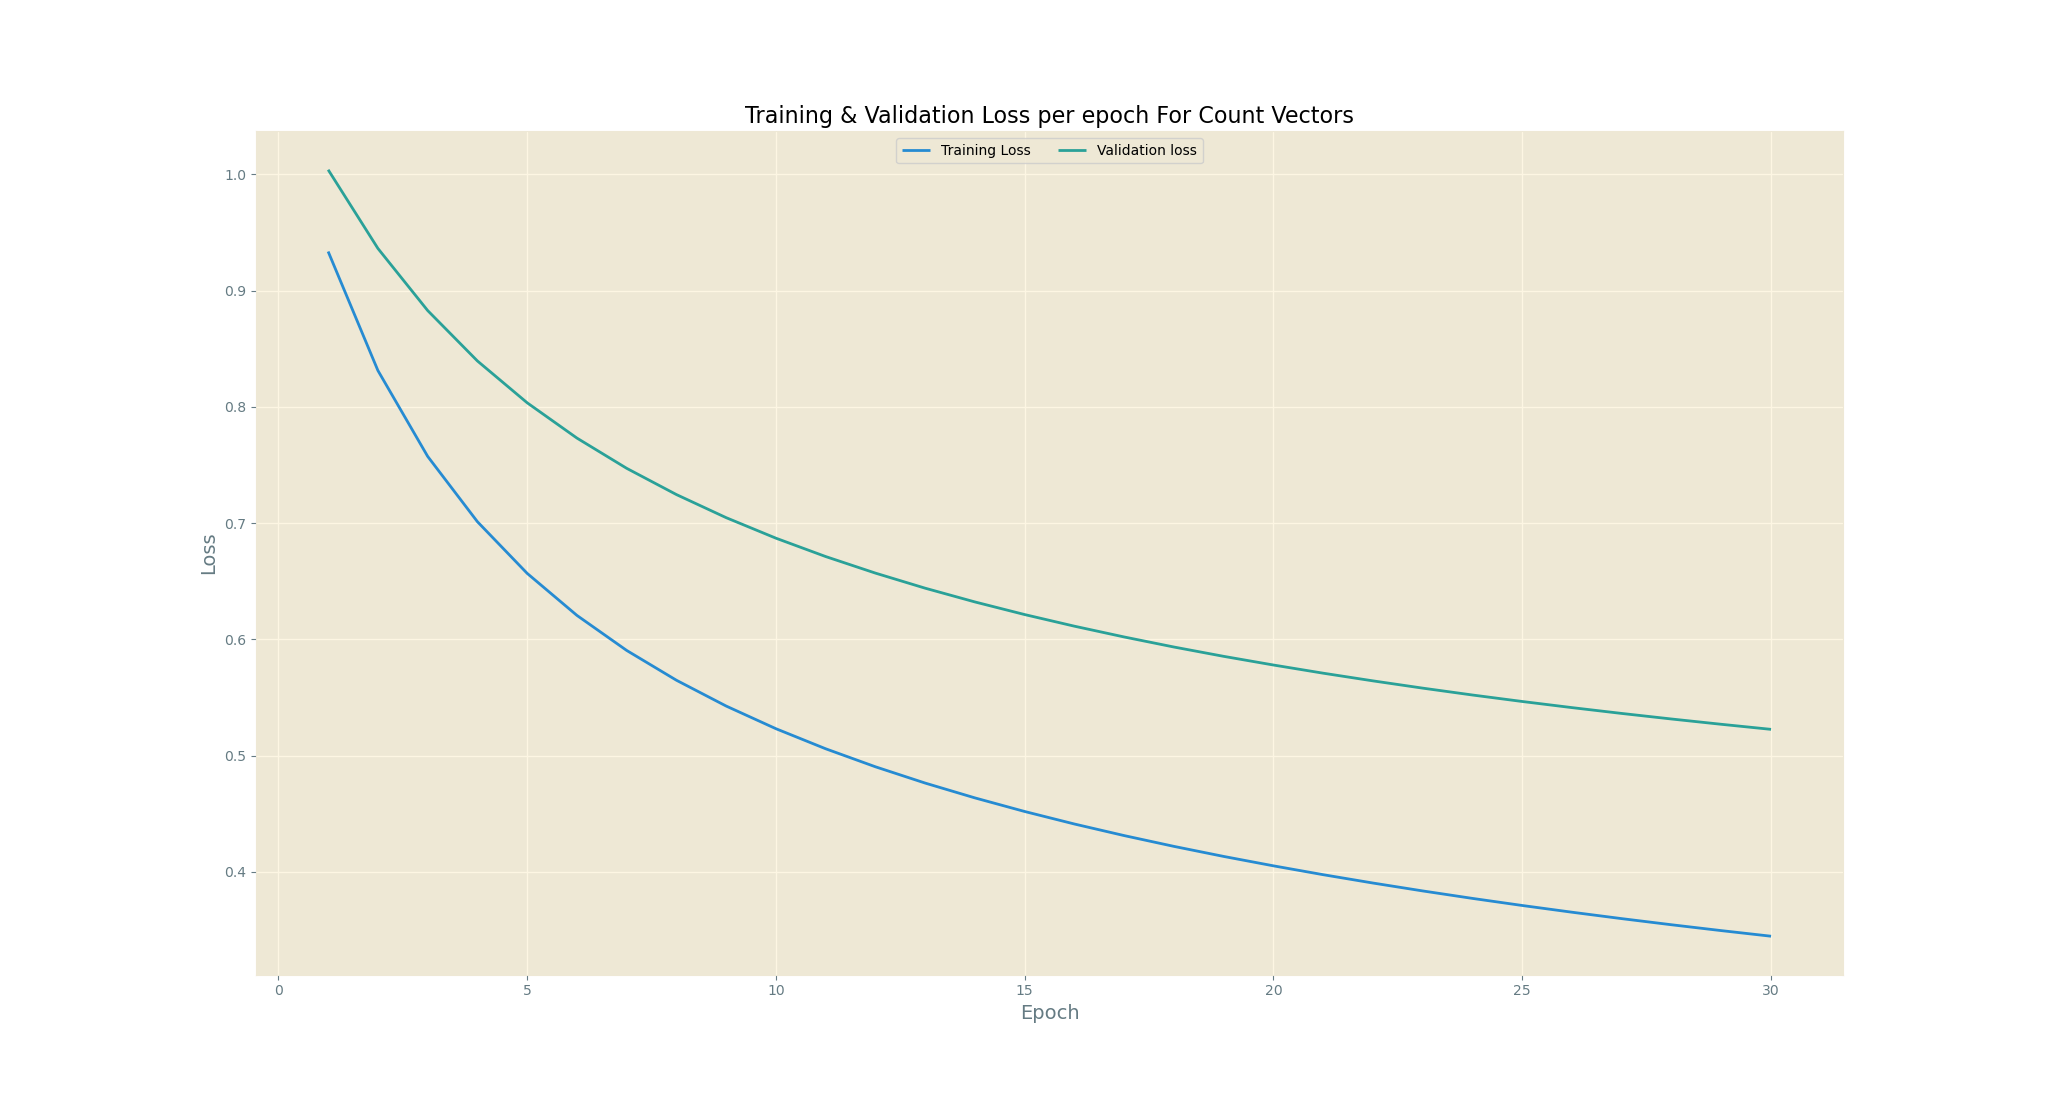

### Discussion

The loss function would indicate that my model is not underfitting. The Fmeasure is reasonably high also which would indicate the model is fitting the data correctly. The loss is not increasing and thus deviating from the true value. The loss value decreases fairly steadily.The loss functions follow a natural log relationship which is to be expected. The function should be converging towards a final value (within tolerance)

In [394]:
preds_te_count = predict_class_multi(topic_X_tr_count, topic_w_count.T)
preds_te_test = predict_class_multi(topic_X_test_count,topic_w_count.T)
preds_test_dev =predict_class_multi(topic_X_dev_tfidf,topic_w_count.T)

#training
print('Accuracy:', accuracy_score(ArrayTest_Topic,preds_te_test))
print('Precision:', precision_score(ArrayTR_Topic,preds_te_count,average='macro'))
print('Recall:', recall_score(ArrayTR_Topic,preds_te_count,average='macro'))
print('F1-Score:', f1_score(ArrayTR_Topic,preds_te_count,average='macro'))


#Dev Set
print("\n\nDev Set")
print('Precision:', precision_score(ArrayDev_Topic,preds_test_dev,average='macro'))
print('Recall:', recall_score(ArrayDev_Topic,preds_test_dev,average='macro'))
print('F1-Score:', f1_score(ArrayDev_Topic,preds_test_dev,average='macro'))

#Test Set
print("\n\nTest Set")
print('Precision:', precision_score(ArrayTest_Topic,preds_te_test,average='macro'))
print('Recall:', recall_score(ArrayTest_Topic,preds_te_test,average='macro'))
print('F1-Score:', f1_score(ArrayTest_Topic,preds_te_test,average='macro'))

Accuracy: 0.8166666666666667
Precision: 0.8916577645459469
Recall: 0.89125
F1-Score: 0.8907450402253367


Dev Set
Precision: 0.7960693895476504
Recall: 0.7933333333333333
F1-Score: 0.7909037180313776


Test Set
Precision: 0.8219710477419145
Recall: 0.8166666666666668
F1-Score: 0.8155863595265244


In [357]:
pos_ind = np.argpartition(topic_w_count[:,0],-10)[-10:] # indexes of 10 largest weights  

positive_words_ind =[]
for i in pos_ind:
    positive_words_ind.append(vocab_id_topic[i])
print("World: ")
print(positive_words_ind) ##world

['President', 'Sunday', 'Iraq', 'after', 'AP', 'Tuesday', 'Monday', 'Wednesday', 'said', 'Reuters']


In [358]:
neg_ind = np.argpartition(topic_w_count[:,1],-10)[-10:] # indexes of 10 largest weights  

neg_words_ind =[]
for i in neg_ind:
    neg_words_ind.append(vocab_id_topic[i])
print("Sports: ")
print(neg_words_ind) ##sports

['Olympics', 'Sunday', 'AP', 'Wednesday', 'Reuters', 'ATHENS', 'night', 'first', 'Tuesday', 'Olympic']


In [359]:
neg_ind = np.argpartition(topic_w_count[:,2],-10)[-10:] # indexes of 10 largest weights  

neg_words_ind2 =[]
for i in neg_ind:
    neg_words_ind2.append(vocab_id_topic[i])
print("Business: ")      
print(neg_words_ind2) ##business

['NEW', 'billion', 'oil', 'Inc', 'prices', 'Wednesday', 'company', 'Tuesday', 'said', 'Reuters']


The words returned make sense. See further on TFIDF multiregression for analysis.

In [361]:
topic_w_tfidf, topic_loss_tr_tfidf, topic_dev_loss_tfidf,epochmax4 = SGDMulti(X_tr =topic_X_tr_tfidf, Y_tr = ArrayTR_Topic, 
                                             X_dev=topic_X_dev_tfidf, 
                                             Y_dev=ArrayDev_Topic,
                                             num_classes=3,
                                             lr=0.001, 
                                             alpha=0.01, 
                                             epochs=4)

Epoch: 1 Training Loss: 0.3680530572222767| Validation Loss: 0.8667346408530011
Epoch: 2 Training Loss: 0.26164791912733565| Validation Loss: 0.7982393465891201
Epoch: 3 Training Loss: 0.21044322605418742| Validation Loss: 0.7581490572357822
Epoch: 4 Training Loss: 0.17804105974072418| Validation Loss: 0.7297362855031574


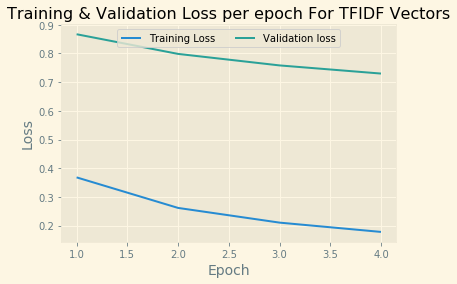

In [377]:
epochs_arr = np.arange(1, (epochmax4 + 2), 1)

with plt.style.context('Solarize_Light2'):
    plt.plot(epochs_arr,topic_loss_tr_tfidf, label = "Training Loss")
    plt.plot(epochs_arr,topic_dev_loss_tfidf,label = "Validation loss")
    plt.xlabel('Epoch', fontsize=14)
    plt.ylabel('Loss', fontsize=14)
    plt.title('Training & Validation Loss per epoch For TFIDF Vectors')
    plt.legend(loc='upper center', bbox_to_anchor=(0.5, 1.00), shadow=False, ncol=2)
plt.show()

### Discussion

The loss function would indicate that my model is not underfitting. The Fmeasure is reasonably high also which would indicate the model is fitting the data correctly. The loss is not increasing and thus deviating from the true value. The loss value decreases fairly steadily. The loss functions follow a natural log relationship which is to be expected. The function should be converging towards a final value (within tolerance)

In [386]:
preds_te = predict_class_multi(topic_X_tr_tfidf, topic_w_tfidf.T)
preds_te_test = predict_class_multi(topic_X_test_tfidf,topic_w_tfidf.T)
preds_test_dev =predict_class_multi(topic_X_dev_tfidf,topic_w_tfidf.T)

##Training Set
print("Training Set")
print('Precision:', precision_score(ArrayTR_Topic,preds_te,average='macro'))
print('Recall:', recall_score(ArrayTR_Topic,preds_te,average='macro'))
print('F1-Score:', f1_score(ArrayTR_Topic,preds_te,average='macro'))

#Dev Set
print("\n\nDev Set")
print('Accuracy:', accuracy_score(ArrayDev_Topic,preds_test_dev))
print('Precision:', precision_score(ArrayDev_Topic,preds_test_dev,average='macro'))
print('Recall:', recall_score(ArrayDev_Topic,preds_test_dev,average='macro'))
print('F1-Score:', f1_score(ArrayDev_Topic,preds_test_dev,average='macro'))

#Test Set
print("\n\nTest Set")
print('Accuracy:', accuracy_score(ArrayTest_Topic,preds_te_test))
print('Precision:', precision_score(ArrayTest_Topic,preds_te_test,average='macro'))
print('Recall:', recall_score(ArrayTest_Topic,preds_te_test,average='macro'))
print('F1-Score:', f1_score(ArrayTest_Topic,preds_te_test,average='macro'))

##results for whole set shown for completeness

Training Set
Precision: 0.9702358475674505
Recall: 0.9700000000000001
F1-Score: 0.9699268536934683


Dev Set
Accuracy: 0.84
Precision: 0.8411240465676434
Recall: 0.84
F1-Score: 0.8400800720648585


Test Set
Accuracy: 0.8644444444444445
Precision: 0.8694700287106736
Recall: 0.8644444444444445
F1-Score: 0.864380510482261


In [378]:
pos_ind = np.argpartition(topic_w_tfidf[:,0],-10)[-10:] # indexes of 10 largest weights  

positive_words_ind =[]
for i in pos_ind:
    positive_words_ind.append(vocab_id_topic[i])
print("World")
print(positive_words_ind) ##world    
neg_ind = np.argpartition(topic_w_count[:,1],-10)[-10:] # indexes of 10 largest weights  

neg_words_ind =[]
for i in neg_ind:
    neg_words_ind.append(vocab_id_topic[i])
print("\nSports")
print(neg_words_ind) ##sports

neg_ind = np.argpartition(topic_w_count[:,2],-10)[-10:] # indexes of 10 largest weights  

neg_words_ind2 =[]
for i in neg_ind:
    neg_words_ind2.append(vocab_id_topic[i])
print("\nBusiness")        
print(neg_words_ind2) ##business

World
['Sunday', 'after', 'ATHENS Greece', 'Greece', 'Tuesday', 'Wednesday', 'AP', 'Monday', 'said', 'AFP']

Sports
['Olympics', 'Sunday', 'AP', 'Wednesday', 'Reuters', 'ATHENS', 'night', 'first', 'Tuesday', 'Olympic']

Business
['NEW', 'billion', 'oil', 'Inc', 'prices', 'Wednesday', 'company', 'Tuesday', 'said', 'Reuters']


## Discussion

The words retrieved make sense for both cases. Personally I think the words for count vectors are more generalised than the ones returned for tf.idf which is the reverse for the binary case. This could be that the set for task 2 is much smaller than that of task one and so idf has less bearing on the prediction.Furthermore the vectors for task 2 are much more sparse than task 1 this is because the documents are much shorter and hence more likelyhood of sparse vectors if vocab length is kept the same at 5000. In retrospect the vocab length should be shorter to accomodate the less populated dataset.

While the results make sense there is signficant crossover between each class and within each class itself. The ngram "Athens Greece" appears while also "Greece" appears for Class 1. The ngrams Tuesday and Wednesday appear in all classes. To further improve the returned words one could remove time phrases using the stoplist. One could also collate Athens Greece and Greece. Stemming can be used to make olympic into one ngram thus avoiding duplication. This could be imported to another domain such as laptop reviews or restuarant but the validity of the model would heavily depend on the classes used. One could use a rated sentiment value as classes,for example, 1 star reviews, 2 star reviews up to 10 stars. 


### Discuss how did you choose model hyperparameters (e.g. learning rate and regularisation strength)? What is the relation between training epochs and learning rate? How the regularisation strength affects performance?

## Discussion

With increasing epochs, the loss value converges. With high regularisation strength the model is less likely to overfit as a constant is being added. However if alpha is too large then the model may underfit. The learning rate dictates how quickly to descend the gradient, a larger learning rate will converge quicker but may overshoot the minimum. A smaller learning rate will take longer to converge but there is no chance of overshooting the minimum.Ideally we choose a large learning rate then decrease the learning rate with epochs to ensure convergence.A small amount of epochs is likely to underfit whereas a large amount of epochs will overfit (if our data is length 2,400 and we do 2,400 shuffles eventually the weights will represent the training data exactly) 

A small learning rate will favour a large amount of epochs as there are more iterations to get closer to the final converging value. If the data is decreasing fairly constitenly i.e decreasing linear gradient then the learning rate should be increased. A large regularisation strength may lead to many falsely classified predictions due to the fact the value will be larger and potentially rounded to the wrong class.

The parameters used for SGD were derived by trial and error (code removed due to runtime and cleanliness) and evaluated using the loss function and fmeasure values. Learning rate was changed while the alpha remained fixed. Once the best performing learning rate was choosen then learning rate was fixed and alpha was changed. Alpha was multiplied by 10 each time until the best value was choosen. This is not the best way of choosing learning parameters, the best way to choose learning parameters is to build a cross validator pipeline using a python library like pyspark. 

Epoch was then decided based on F-measure once the other parameters were chosen.I defined a tolerance for f-measure and worked out the amount of epochs to reach the tolerance. The value of epoch obtained was fairly low which is suprising as usually epoch needs to be considerably larger. This could be because my code does multiple passes in one iteration of epoch. If runtime was not a consideration then additional epochs could be accomplished.

Note that task 2 takes considerably longer to run than task 1. The training data is larger but the documents are less densely populated. However more calculations need to take place as now we have  large matrices (2400 x 5000) as opposed to row vectors. In order to test epoch better in the timeframe of this assignment the HPC was used. See figure below for an example using the count vectors.
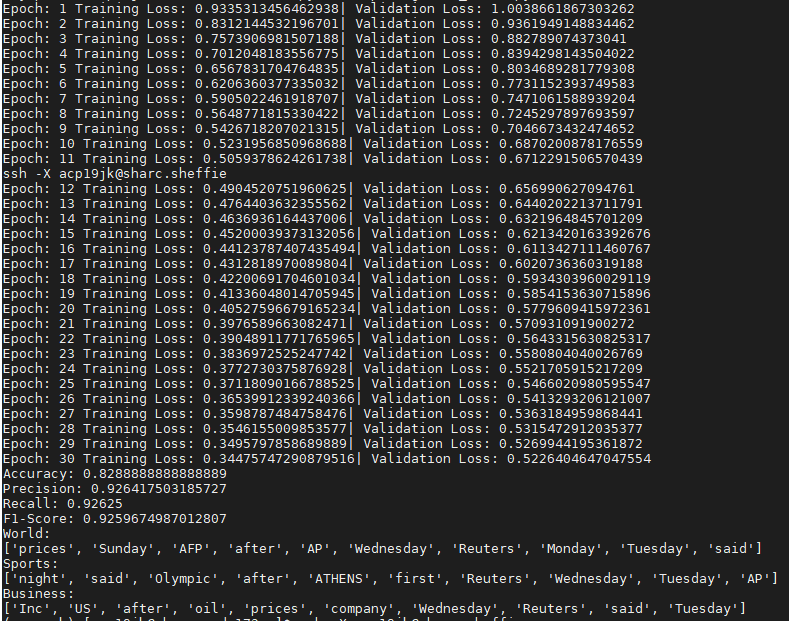

## Full Results



| LR | Precision  | Recall  | F1-Score  |
|:-:|:-:|:-:|:-:|
| BOW-count  |  0.82 | 0.82  |0.82   |
| BOW-tfidf  | 0.87  |0.87   |0.83   |
